In [1]:
import json
import pandas as pd
import numpy as np
import nltk
import string
import re
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
nltk.download("state_union")

[nltk_data] Downloading package state_union to /root/nltk_data...
[nltk_data]   Unzipping corpora/state_union.zip.


True

In [4]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [5]:
# Seteos globales de warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Opción de Pandas para visualizar todas las columnas
pd.set_option('display.max_columns', None)

In [7]:
# funcion para autorizar la lectura de los archivos a google colab
# antes de leer un archivo, si IN_COLAB es True, llamar a esta funcion con el nombre del archivo y el link con que se compartió en google drive
def auth_colab(file, link):
    try:
        import google.colab
    except:
        return # si no logra importar google.colab, no hace nada (no estas ejecutando en este entorno)
    # Solo si estas en google colab, autorizar la lectura del archivo

    # Code to read csv file into Colaboratory:
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    id = link.split('/')[-2] # se queda con lo que esta entre la anteultima y la ultima '/', eso es el id que necesito
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile( file )

In [8]:
file_name = 'Sarcasm_Headlines_Dataset.json'
auth_colab( file_name, 'https://drive.google.com/file/d/12iBuqdyPOqHBIIg4cSCKtkNWVAN7DtFF/view?usp=sharing' )

data = pd.read_json(file_name, lines=True)

data

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


In [9]:
#Función para hacer el sampleo balanceado, ver de mejorar un poco
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

In [10]:
#Sample 2000 muestras 1000 y 1000
data_cut=stratified_sample_df(data,"is_sarcastic",1000)

In [11]:
data_cut.is_sarcastic.value_counts(normalize=True)

1    0.5
0    0.5
Name: is_sarcastic, dtype: float64

In [12]:
data=data_cut.copy()
data

,article_link,headline,is_sarcastic
22574,https://www.huffingtonpost.com/entry/leigh-ste...,los angeles lakers -- oh how the mighty have f...,0
15390,https://www.huffingtonpost.com/entry/milo-vent...,milo ventimiglia strips down to raise awarenes...,0
16236,https://www.huffingtonpost.com/entry/7-sweet-t...,7 sweet treats for mother's day,0
25622,https://www.huffingtonpost.comhttp://www.thegu...,marc andreessen's 'colonialism' gaffe? a sympt...,0
4021,https://www.huffingtonpost.com/entry/congress-...,here's what congress is doing about lead pipes...,0
...,...,...,...
24123,https://www.theonion.com/little-debbie-conquer...,little debbie conquers jenny craig in midnight...,1
8839,https://www.theonion.com/hero-lawyer-uses-tech...,hero lawyer uses technicality to free guilty man,1
11312,https://local.theonion.com/priest-regrets-vow-...,priest regrets vow of celibacy after learning ...,1
14462,https://www.theonion.com/jamie-crying-1819564111,jamie crying,1


In [13]:
# Evaluation function
def evaluation(y_true, y_pred, y_proba=[], verbose=0):
    
    if verbose == 1:
        # Print Accuracy, Recall, F1 Score, and Precision metrics.
        print('Evaluation Metrics:')
        print('Accuracy:   ' + str(metrics.accuracy_score(y_true, y_pred)))
        print('Recall:     ' + str(metrics.recall_score(y_true, y_pred)))
        print('F1 Score:   ' + str(metrics.f1_score(y_true, y_pred)))
        print('Precision:  ' + str(metrics.precision_score(y_true, y_pred)))
        if y_proba == []:
            print('ROC_AUC:    ' + str(metrics.roc_auc_score(y_true, y_pred)))
        else:
            print('ROC_AUC:    ' + str(metrics.roc_auc_score(y_true, y_proba)))
            
        #print('MAE = {}'.format(metrics.mean_absolute_error(y_true, y_pred)))
        #print('RMSD = {}'.format(np.sqrt(metrics.mean_squared_error(y_true, y_pred))))
        
        # Print Confusion Matrix
        print('\nConfusion Matrix:')
        print('   TN   FP   FN   TP')
        conf_mat = metrics.confusion_matrix(y_true, y_pred)
        print(conf_mat.ravel())
        print()
        conf_mat_df = pd.DataFrame(data=conf_mat,
                                   index=['Actual Negative: 0', 'Actual Positive: 1'],
                                   columns=['Predict Negative: 0', 'Predict Positive: 1'])
        
        sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='YlGnBu');
                
    Accuracy = metrics.accuracy_score(y_true, y_pred).round(3)
    Recall = metrics.recall_score(y_true, y_pred).round(3)
    F1_Score = metrics.f1_score(y_true, y_pred).round(3)
    Precision = metrics.precision_score(y_true, y_pred).round(3)
    if y_proba == []:
        Roc_auc = metrics.roc_auc_score(y_true, y_pred).round(3)        
    else:
        Roc_auc = metrics.roc_auc_score(y_true, y_proba).round(3)
        
    #MAE = metrics.mean_absolute_error(y_true, y_pred).round(3)
    #RMSD = metrics.mean_squared_error(y_true, y_pred).round(3)
    
    final = []
    final.append(Accuracy)
    final.append(Recall)
    final.append(F1_Score)
    final.append(Precision)
    final.append(Roc_auc)
    #final.append(MAE)
    #final.append(RMSD)
    cm = metrics.confusion_matrix(y_true, y_pred)
    for t in cm[0]:
        final.append(t)
    for t in cm[1]:
        final.append(t)
    
    return final

In [14]:
pd.set_option('display.max_colwidth', 100) # To extend column width

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

In [15]:
import string

# Function to calculate length of message excluding space
data['headline_len'] = data['headline'].apply(lambda x: len(x) - x.count(" "))

data.head()

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['punct%'] = data['headline'].apply(lambda x: count_punct(x))

data.head()

,article_link,headline,is_sarcastic,headline_len,punct%
22574,https://www.huffingtonpost.com/entry/leigh-steinberg-blog-los-_b_6220100.html,los angeles lakers -- oh how the mighty have fallen,0,42,4.8
15390,https://www.huffingtonpost.com/entry/milo-ventimiglia-strips-down-to-raise-awareness-for-breast-...,milo ventimiglia strips down to raise awareness for breast cancer on 'ellen',0,65,3.1
16236,https://www.huffingtonpost.com/entry/7-sweet-treats-for-mothers-day_b_7189022.html,7 sweet treats for mother's day,0,26,3.8
25622,https://www.huffingtonpost.comhttp://www.theguardian.com/technology/2016/feb/11/marc-andreessens...,marc andreessen's 'colonialism' gaffe? a symptom of silicon valley bias,0,62,6.5
4021,https://www.huffingtonpost.com/entry/congress-flint_us_56d0a37be4b0871f60eb4ab6,here's what congress is doing about lead pipes in flint and elsewhere,0,58,1.7


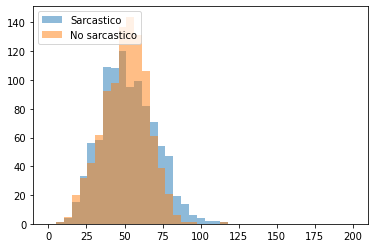

In [16]:
bins = np.linspace(0, 200, 40)

plt.hist(data[data['is_sarcastic']==1]['headline_len'], bins, alpha=0.5,  label='Sarcastico')
plt.hist(data[data['is_sarcastic']==0]['headline_len'], bins, alpha=0.5, label='No sarcastico')
plt.legend(loc='upper left')
plt.show()

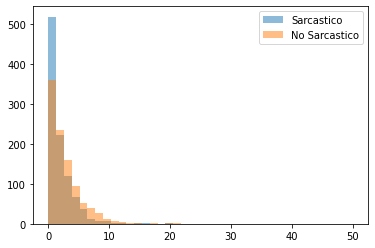

In [17]:
bins = np.linspace(0, 50, 40)

plt.hist(data[data['is_sarcastic']==1]['punct%'], bins, alpha=0.5,  label='Sarcastico')
plt.hist(data[data['is_sarcastic']==0]['punct%'], bins, alpha=0.5,  label='No Sarcastico')
plt.legend(loc='upper right')
plt.show()

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [19]:
def clean_text(text):
    
#1. Remove punctuation
#Punctuation can provide grammatical context to a sentence 
#which supports our understanding. But for our vectorizer
#which counts the number of words and not the context, it does not add value,
#so we remove all special characters. eg: How are you?->How are you
    text = "".join([word.lower() for word in text if word not in string.punctuation])
#2.Tokenization
#Tokenizing separates text into units such as sentences or words.
#It gives structure to previously unstructured text. 
#eg: Plata o Plomo-> ‘Plata’,’o’,’Plomo’.  
    tokens = re.split('\W+', text)
#Preprocessing Data: Lemmatizing 
#Lemmatizing derives the canonical form (‘lemma’) of a word.
#i.e the root form. It is better than stemming as it uses a 
#dictionary-based approach i.e a morphological analysis 
#to the root word.eg: Entitling, Entitled->Entitle
# AND remove all stopwords
    wn = nltk.WordNetLemmatizer()
    #text = [ps.stem(word) for word in tokens if word not in stopwords]
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    
    return text


In [20]:
X=data[["headline","headline_len","punct%"]]
Y=data['is_sarcastic']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1, test_size=.30, stratify=Y)

In [22]:
##Fit de la vectorización


tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['headline'])

tfidf_train = tfidf_vect_fit.transform(X_train['headline'])
tfidf_test = tfidf_vect_fit.transform(X_test['headline'])

X_train_vect = pd.concat([X_train[['headline_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['headline_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

headline_len  punct%    0    1    2    3    4    5    6    7    8    9  \
0            43     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1            48     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2            25     4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3            32     3.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4            80     2.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    10   11   12   13   14   15   16   17   18   19   20   21   22   23   24  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    25   26   27   28   29   30   31   32   33   34   35   36   37   38   39  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    40   41   42   43   44   45   46   47   48   49   50   51   52   53   54  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    55   56   57   58   59   60   61   62   63   64   65   66   67   68   69  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    70   71   72   73   74   75   76   77   78   79   80   81   82   83   84  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    85   86   87   88   89   90   91   92   93   94   95   96   97   98   99  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   100  101  102  103  104  105  106  107  108       109  110  111  112  113  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.554758  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0   

   114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  

In [23]:
Y.value_counts(normalize=True)

1    0.5
0    0.5
Name: is_sarcastic, dtype: float64

In [24]:

rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

rf_model = rf.fit(X_train_vect, y_train)

y_pred = rf_model.predict(X_test_vect)



In [25]:
y_pred_RFc_proba_test = rf_model.predict_proba(X_test_vect)[:, 1]
y_pred_RFc_proba_train = rf_model.predict_proba(X_train_vect)[:, 1]
y_pred_RFc_test = rf_model.predict(X_test_vect)
y_pred_RFc_train = rf_model.predict(X_train_vect)

Resultados de Valores de TRAIN Random Forest

Evaluation Metrics:
Accuracy:   1.0
Recall:     1.0
F1 Score:   1.0
Precision:  1.0
ROC_AUC:    1.0

Confusion Matrix:
   TN   FP   FN   TP
[700   0   0 700]



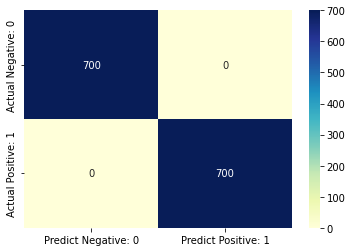

In [26]:
print('Resultados de Valores de TRAIN Random Forest')
print()
evaluation(y_train, y_pred_RFc_train, y_pred_RFc_proba_train, verbose=1);

Resultados de Valores de TEST Random Forest

Evaluation Metrics:
Accuracy:   0.6783333333333333
Recall:     0.6533333333333333
F1 Score:   0.6700854700854701
Precision:  0.6877192982456141
ROC_AUC:    0.7446777777777778

Confusion Matrix:
   TN   FP   FN   TP
[211  89 104 196]



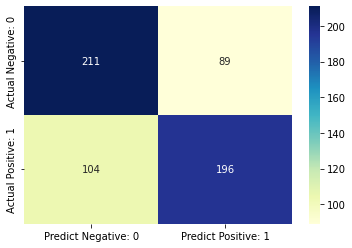

In [27]:
print('Resultados de Valores de TEST Random Forest')
print()
evaluation(y_test, y_pred_RFc_test, y_pred_RFc_proba_test, verbose=1);